In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from datetime import *

In [2]:
# Inspiration came from: https://www.askpython.com/python/examples/stock-price-prediction-python

# Load Data

In [3]:
df = pd.read_csv("../data/GME.csv")
final_data = df.iloc[23:63]
final_data = final_data[::-1].reset_index(drop=True)
# final_data = final_data.drop(columns="change")
final_data.head()

,timestamp,open,high,low,close,volume
0,2022-01-31,97.87,109.8199,97.8600,108.93,3499273
1,2022-02-01,113.01,116.6500,108.2649,112.60,3461877
2,2022-02-02,110.35,111.8599,98.0600,100.04,3279135
3,2022-02-03,101.50,106.9400,97.7100,99.23,2677519
4,2022-02-04,99.01,104.0000,95.0800,102.34,1906791


# Visualize Data

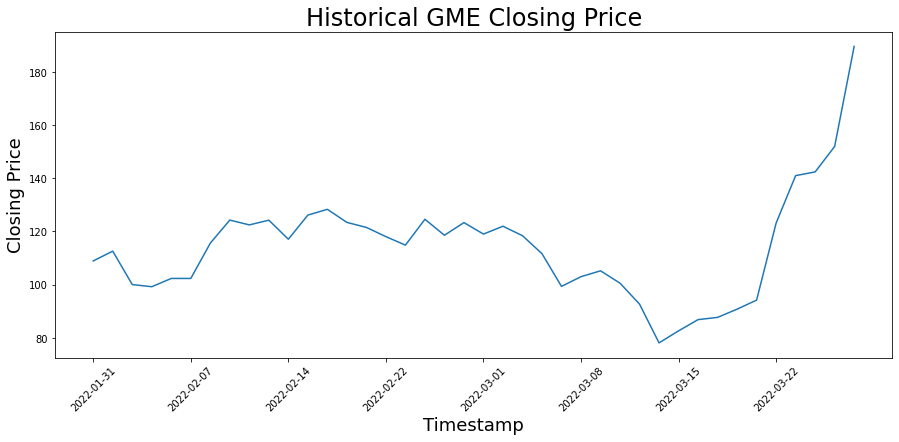

In [4]:
plt.figure(figsize = (15,6))
plt.plot(final_data["timestamp"], final_data["close"])
plt.xticks(range(0,final_data.shape[0], 5), final_data['timestamp'].loc[::5],rotation=45)
plt.xlabel('Timestamp',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title("Historical GME Closing Price", fontsize=24)
plt.savefig("HistoricalGME.jpg")
plt.show()

# Data Preprocessing

In [5]:
# 1. Filter out the closing market price data
close_data = final_data.filter(['close'])
 
# 2. Convert the data into array for easy evaluation
dataset = close_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
# 4. Creating training data size : 75% of the data
training_data_len = math.ceil(len(dataset) *.75)
train_data = scaled_data[0:training_data_len  , : ]
 
# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(3,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-3:i,0])
    y_train_data.append(train_data[i,0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training s and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))


# Build the LSTM Model

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

2022-05-17 11:50:40.931659: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Compile the Model

In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=30)

Epoch 1/30
27/27 [==============================] - 2s 3ms/step - loss: 0.0302
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 5/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 6/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 7/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 8/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 9/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 10/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 11/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 12/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 13/30
27/27 [==============================

# Test the Model

In [8]:
# 1. Creating a dataset for testing
test_data = scaled_data[training_data_len - 3: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(3,len(test_data)):
    x_test.append(test_data[i-3:i,0])
    
# 2. Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

## RMSE

In [9]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

23.66202892058117


/var/folders/60/119q0_pn0fzgzlht5v1c51h00000gn/T/ipykernel_95537/784433906.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


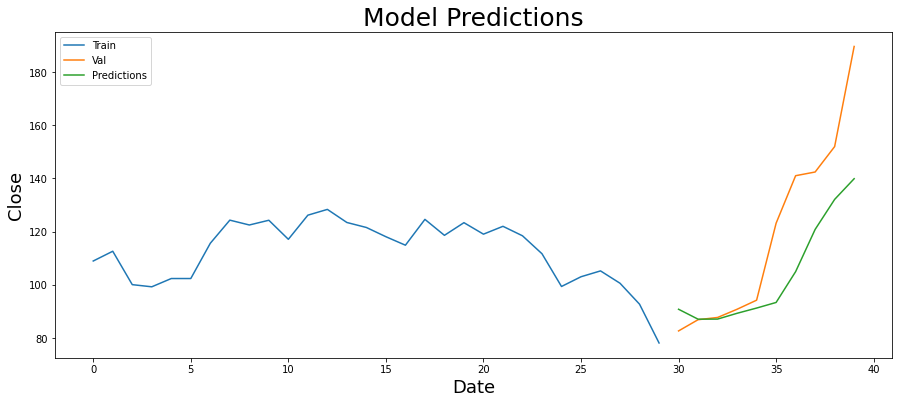

In [10]:
training_data_len = math.ceil(len(dataset) *.75)

train = final_data[:training_data_len]
valid = final_data[training_data_len:]
 
valid['Predictions'] = predictions
 
plt.figure(figsize = (15,6))
plt.title('Model Predictions',fontsize=25)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close',fontsize=18)
 
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
 
plt.savefig("gmeBasicPrediction.jpg")
plt.show()

# With Comment Data

## Load Data

In [11]:
df = pd.read_csv("../data/GME.csv")
final_data = df.iloc[23:63]
final_data = final_data[::-1].reset_index(drop=True)
#final_data = final_data.drop(columns="change")

comment_df = pd.read_csv("../data/gme_comment_data.csv")
comment_df.head()

,Unnamed: 0,Mention Count,Mean Sent Score,Scores StdDev
0,1/31/2022,11,-0.043973,0.298081
1,2/1/2022,38,0.051024,0.259325
2,2/2/2022,36,-0.039461,0.477875
3,2/3/2022,1,0.000000,0.000000
4,2/4/2022,16,-0.064706,0.437461


## Merge Data

In [12]:
final_data = final_data.join(comment_df)
final_data.to_csv("merged_gme.csv")
final_data = final_data.drop(columns=["Unnamed: 0"])
final_data

,timestamp,open,high,low,close,volume,Mention Count,Mean Sent Score,Scores StdDev
0,2022-01-31,97.870,109.8199,97.8600,108.93,3499273,11,-0.043973,0.298081
1,2022-02-01,113.010,116.6500,108.2649,112.60,3461877,38,0.051024,0.259325
2,2022-02-02,110.350,111.8599,98.0600,100.04,3279135,36,-0.039461,0.477875
3,2022-02-03,101.500,106.9400,97.7100,99.23,2677519,1,0.000000,0.000000
4,2022-02-04,99.010,104.0000,95.0800,102.34,1906791,16,-0.064706,0.437461
5,2022-02-07,102.990,105.3849,98.7700,102.34,1759360,13,-0.027869,0.290657
6,2022-02-08,101.755,117.6717,100.5500,115.60,4959906,7,0.193457,0.256715
7,2022-02-09,114.090,124.7100,113.0000,124.29,3866895,2,-0.255300,0.361049
8,2022-02-10,117.950,131.7800,116.0000,122.47,3706537,1,0.000000,0.000000
9,2022-02-11,122.480,129.8668,120.7706,124.25,2824777,26,-0.016312,0.445887


# Visualize Data

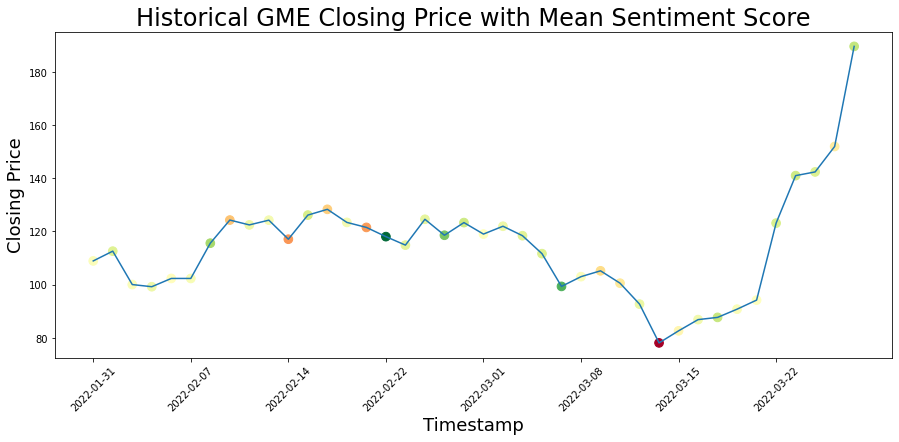

In [13]:
plt.figure(figsize = (15,6))
plt.scatter(final_data["timestamp"], final_data["close"], c=final_data["Mean Sent Score"], cmap="RdYlGn", s=75)

plt.plot(final_data["timestamp"], final_data["close"])
plt.xticks(range(0,final_data.shape[0],5), final_data['timestamp'].loc[::5],rotation=45)
plt.xlabel('Timestamp',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title("Historical GME Closing Price with Mean Sentiment Score", fontsize=24)
plt.savefig("historicalWithSentiment.jpg")
plt.show()

## Data Preprocessing

In [14]:
# 1. Filter out the closing market price data
close_data = final_data.filter(['close', 'Mention Count', 'Mean Sent Score', 'Scores StdDev'])
 
# 2. Convert the data into array for easy evaluation
dataset = close_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
# 4. Creating training data size : 70% of the data
training_data_len = math.ceil(len(dataset) *.75)
train_data = scaled_data[0:training_data_len  , : ]
 
# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(3,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-3 : i, 0])
    y_train_data.append(train_data[i, 0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training s and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))

In [15]:
x_train_data2.shape

(27, 3, 1)

## Build the Model

In [16]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=4))

## Compile the Model

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=30)

Epoch 1/30
27/27 [==============================] - 2s 3ms/step - loss: 0.0471
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 5/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 6/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 7/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 8/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 9/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 10/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 11/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 12/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 13/30
27/27 [==============================

## Test the Model

In [18]:
# 1. Creating a dataset for testing
test_data = scaled_data[training_data_len - 3: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(3,len(test_data)):
    print(test_data[i-3 : i+1, 0 ])
    x_test.append(test_data[i-3:i, 0])
    
# 2. Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

[0.20138141 0.13078579 0.         0.04063509]
[0.13078579 0.         0.04063509 0.07848942]
[0.         0.04063509 0.07848942 0.0860244 ]
[0.04063509 0.07848942 0.0860244  0.11374238]
[0.07848942 0.0860244  0.11374238 0.14433082]
[0.0860244  0.11374238 0.14433082 0.40392896]
[0.11374238 0.14433082 0.40392896 0.56413706]
[0.14433082 0.40392896 0.56413706 0.57660567]
[0.40392896 0.56413706 0.57660567 0.66236096]
[0.56413706 0.57660567 0.66236096 1.        ]


In [19]:
final_predictions = []
for item in predictions:
    final_predictions.append(item[0])

## RMSE

In [20]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

19.47265992833127


/var/folders/60/119q0_pn0fzgzlht5v1c51h00000gn/T/ipykernel_95537/4213794319.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = final_predictions


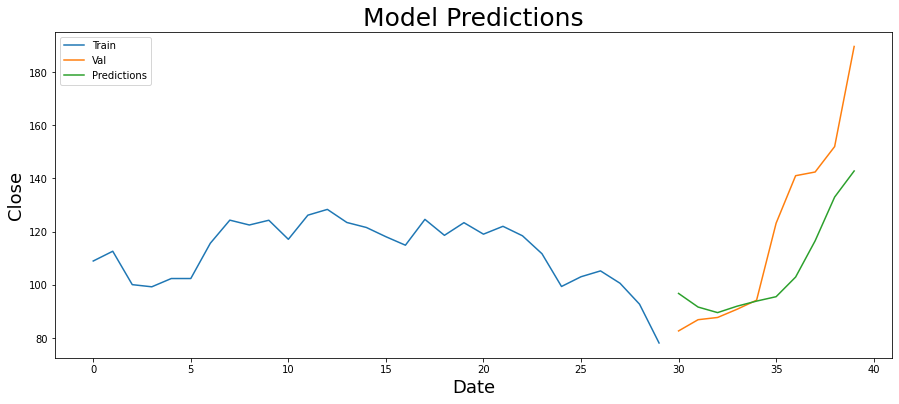

In [21]:
training_data_len = math.ceil(len(dataset) *.75)

train = final_data[:training_data_len]
valid = final_data[training_data_len:]
 
valid['Predictions'] = final_predictions
 
plt.figure(figsize = (15,6))
plt.title('Model Predictions',fontsize=25)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close',fontsize=18)
 
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
 
plt.savefig("gmePredictionWithSent.jpg")
plt.show()


In [22]:
###########################################################################################

In [23]:
###########################################################################################

# New Attempt at With Sentiment Prediction

In [24]:
df = pd.read_csv("../data/GME.csv")
final_data = df.iloc[23:63] # Just data we have comments for
final_data = final_data[::-1].reset_index(drop=True)
#final_data = final_data.drop(columns="change")

comment_df = pd.read_csv("../data/gme_comment_data.csv")

final_data = final_data.join(comment_df)
final_data.to_csv("merged_gme.csv")
final_data = final_data.drop(columns=["Unnamed: 0"])
final_data = final_data.drop(columns=["open", "high", "low", "volume"])

final_data = final_data.set_index("timestamp")

training_data_len = math.ceil(len(final_data) *.75)
train_data = final_data[:30]
test_data = final_data[30:]

In [25]:
final_data.head()

,close,Mention Count,Mean Sent Score,Scores StdDev
timestamp,,,,
2022-01-31,108.93,11,-0.043973,0.298081
2022-02-01,112.60,38,0.051024,0.259325
2022-02-02,100.04,36,-0.039461,0.477875
2022-02-03,99.23,1,0.000000,0.000000
2022-02-04,102.34,16,-0.064706,0.437461


In [26]:
train_set = train_data.iloc[:, 0:4].values

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

X_train = []
y_train = []
for i in range(3, 30): 
    #print(training_set_scaled[i-3:i])
    X_train.append(training_set_scaled[i-3:i]) # add all the data in the row
    y_train.append(training_set_scaled[i, 0])  # add the closing data
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [27]:
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 4)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=4))

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=30,batch_size=1)

Epoch 1/30
27/27 [==============================] - 3s 3ms/step - loss: 0.3285
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0640
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0617
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0491
Epoch 5/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 6/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0448
Epoch 7/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 8/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 9/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 10/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0374
Epoch 11/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 12/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 13/30
27/27 [==============================

In [28]:
test_set = test_data.iloc[:, 0:4].values # Scale the data with the same transform as the training data
test_set_scaled = sc.transform(test_set)

In [29]:
X_test = []
y_test = []

for i in range(3, 10):
    #print(training_set_scaled[i-3:i])
    X_test.append(test_set_scaled[i-3:i])
    y_test.append(test_set_scaled[i, 0]) 
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

## RMSE

In [30]:
predictions = model.predict(X_test)
predicted_Price = sc.inverse_transform(predictions)

In [31]:
results = [] 

for predict in predicted_Price:
    results.append(predict[0]) # Grab the closing price predictions

In [32]:
test_data = test_data.iloc[3:]
test_data["predictions"] = results 

In [33]:
rmse=np.sqrt(np.mean(((results - test_data["close"])**2)))
print(rmse)

37.56248450636816


# Visualizing

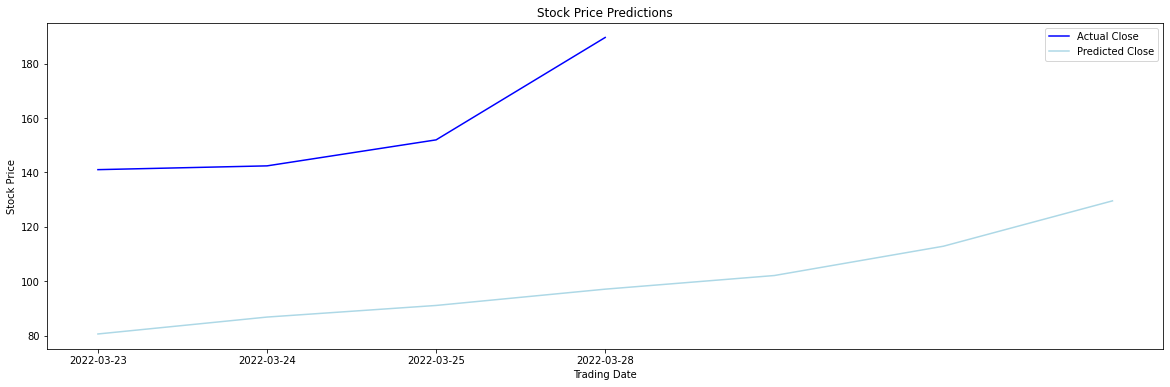

In [34]:
# Visualising the results
import matplotlib.pyplot as plt

plt.plot(test_data['close'].iloc[3:], color = 'blue', label = 'Actual Close') 
plt.plot(results, color = 'lightblue', label = 'Predicted Close')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

/var/folders/60/119q0_pn0fzgzlht5v1c51h00000gn/T/ipykernel_95537/1443556198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = final_predictions


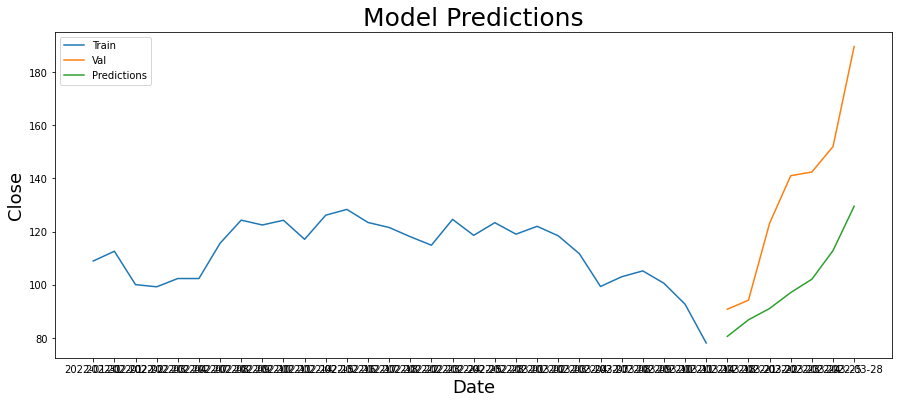

In [35]:
training_data_len = math.ceil(len(dataset) *.75)
 
valid['Predictions'] = final_predictions
 
plt.figure(figsize = (15,6))
plt.title('Model Predictions',fontsize=25)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close',fontsize=18)
 
plt.plot(train_data['close'])
plt.plot(test_data['close'])
plt.plot(test_data['predictions'])

 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
 
plt.savefig("gmePredictionWithSent.jpg")
plt.show()